In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
balraj98_massachusetts_roads_dataset_path = kagglehub.dataset_download('balraj98/massachusetts-roads-dataset')

print('Data source import complete.')


Data source import complete.


Let's inspect a few images from the dataset.

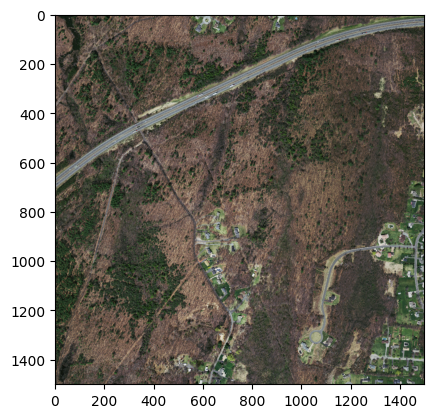

In [ ]:
import matplotlib.pyplot as plt


import cv2


image = cv2.imread("/kaggle/input/massachusetts-roads-dataset/tiff/test/10378780_15.tiff")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The dataset consists of $151$ aerial images of the Boston area. It covers mostly urban and suburban areas and buildings of all sizes. Each of the images has $1500 \times 1500$ pixels for an area of $2.25$ square kilometers. In total the dataset covers $340$ square kilometers area.

An accompanying **metadata.csv** is provided with each image ID, the split it belongs to, image urls and path to it.

In [ ]:
IMG_ROOT = '/root/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/'
df = pd.read_csv('/root/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/metadata.csv')

train_df = df.loc[df['split'] == 'train']
tst_df = df.loc[df['split'] == 'test']

Here is the code to pick random crop from middle.

In [ ]:
pd.read_csv('/root/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/metadata.csv')

,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,10078660_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif,png/train/10078660_15.png,png/train_labels/10078660_15.png
1,10078675_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif,png/train/10078675_15.png,png/train_labels/10078675_15.png
2,10078690_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078690_15.tiff,tiff/train_labels/10078690_15.tif,png/train/10078690_15.png,png/train_labels/10078690_15.png
3,10078705_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078705_15.tiff,tiff/train_labels/10078705_15.tif,png/train/10078705_15.png,png/train_labels/10078705_15.png
4,10078720_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078720_15.tiff,tiff/train_labels/10078720_15.tif,png/train/10078720_15.png,png/train_labels/10078720_15.png
...,...,...,...,...,...,...,...,...
1166,25079170_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/25079170_15.tiff,tiff/test_labels/25079170_15.tif,png/test/25079170_15.png,png/test_labels/25079170_15.png
1167,26278720_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/26278720_15.tiff,tiff/test_labels/26278720_15.tif,png/test/26278720_15.png,png/test_labels/26278720_15.png
1168,26428735_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/26428735_15.tiff,tiff/test_labels/26428735_15.tif,png/test/26428735_15.png,png/test_labels/26428735_15.png
1169,26578720_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/26578720_15.tiff,tiff/test_labels/26578720_15.tif,png/test/26578720_15.png,png/test_labels/26578720_15.png


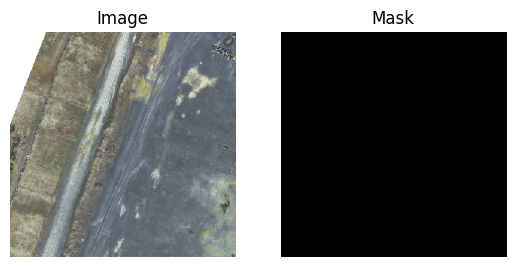

In [ ]:
import random
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader



class BuildingDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT):
        self.df = df
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        crop_size = 224
        img_path = self.root + self.df.iloc[idx]['tiff_image_path']
        mask_path = self.root + self.df.iloc[idx]['tif_label_path']
        # img_path = img_path.replace("png", "tiff")

        # print(img_path)
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Convert mask to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # Get original image dimensions
        H, W, _ = img.shape

        # Ensure crop size fits
        if H < crop_size or W < crop_size:
            raise ValueError(f"Image too small for 224x224 crop: {H}x{W}")

        # Pick random crop coordinates near the center
        center_x, center_y = W // 2, H // 2
        max_offset_x = (W - crop_size) // 2
        max_offset_y = (H - crop_size) // 2

        rand_offset_x = random.randint(max(0, center_x - max_offset_x), min(W - crop_size, center_x + max_offset_x))
        rand_offset_y = random.randint(max(0, center_y - max_offset_y), min(H - crop_size, center_y + max_offset_y))

        img_cropped = img[rand_offset_y:rand_offset_y+crop_size, rand_offset_x:rand_offset_x+crop_size]
        mask_cropped = mask[rand_offset_y:rand_offset_y+crop_size, rand_offset_x:rand_offset_x+crop_size]

        return img_cropped, mask_cropped

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy() / 255.0)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks


tr_ds = BuildingDataset(train_df)
tst_ds = BuildingDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tst_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[13]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[:, :, :], cmap = "gray")
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')  # show mask in grayscale
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()


With the same reasoning that we provided for training building segmentation maps, we would be using (224 x 244) crops. However when we tried the center crop like the building dataset most datapoints gave empty masks, as roads are much more sparer. So we came up with a logic to find out the crops with roads in them. 

In [ ]:
import random
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

class RoadDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT, crop_size=224, max_tries=10):
        self.df = df
        self.root = root
        self.crop_size = crop_size
        self.max_tries = max_tries

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        crop_size = self.crop_size
        img_path = self.root + self.df.iloc[idx]['tiff_image_path']
        mask_path = self.root + self.df.iloc[idx]['tif_label_path']

        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Image not found at {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Mask not found at {mask_path}")

        H, W = mask.shape

        # Ensure crop size fits
        if H < crop_size or W < crop_size:
            raise ValueError(f"Image too small for crop: {H}x{W}")

        # Try multiple times to find a crop with road pixels and not mostly white
        for _ in range(self.max_tries):
            rand_x = random.randint(0, W - crop_size)
            rand_y = random.randint(0, H - crop_size)

            img_crop = img[rand_y:rand_y+crop_size, rand_x:rand_x+crop_size]
            mask_crop = mask[rand_y:rand_y+crop_size, rand_x:rand_x+crop_size]

            # Check if mask has road pixels
            has_road = mask_crop.sum() > 0

            # Check if image is more than 90% white
            white_pixel_ratio = np.mean(np.all(img_crop >= 250, axis=-1))  # True if R,G,B >= 250
            is_mostly_white = white_pixel_ratio > 0.9

            if has_road and not is_mostly_white:
                return img_crop, mask_crop

        # Fallback: random crop without road/white check
        rand_x = random.randint(0, W - crop_size)
        rand_y = random.randint(0, H - crop_size)
        img_crop = img[rand_y:rand_y+crop_size, rand_x:rand_x+crop_size]
        mask_crop = mask[rand_y:rand_y+crop_size, rand_x:rand_x+crop_size]
        return img_crop, mask_crop

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy() / 255.0)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks


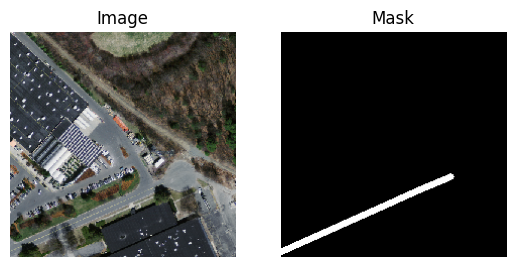

In [ ]:
tr_ds = RoadDataset(train_df)
tst_ds = RoadDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tst_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[random.randint(0, len(tr_ds))]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[:, :, :], cmap = "gray")
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')  # show mask in grayscale
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()

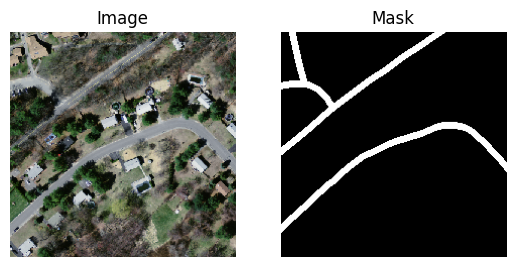

In [ ]:
tr_ds = RoadDataset(train_df)
tst_ds = RoadDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tst_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[random.randint(0, len(tr_ds))]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[:, :, :], cmap = "gray")
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')  # show mask in grayscale
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()

Like the Building segmentation model we define a UNet model with cross entropy loss and train  it on a Adam optimizer for 50 epochs.

In [ ]:
import torch.nn as nn
from torchvision.models import vgg16_bn

def conv(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3,
                stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
     nn.ConvTranspose2d(in_channels, out_channels,
                         kernel_size=2, stride=2),
     nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.backbone = vgg16_bn(pretrained=True).to(device).features
        self.down1 = nn.Sequential(*self.backbone[:6]) # 64
        self.down2 = nn.Sequential(*self.backbone[6:13]) # 128
        self.down3 = nn.Sequential(*self.backbone[13:20]) # 256
        self.down4 = nn.Sequential(*self.backbone[20:27]) # 512
        self.down5 = nn.Sequential(*self.backbone[27:34]) # 512

        self.bottleneck = nn.Sequential(*self.backbone[34:]) # 512
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.merge_conv5 = conv(512+512, 512)
        self.up_conv4 = up_conv(512, 256)
        self.merge_conv4 = conv(512 + 256, 256)
        self.up_conv3 = up_conv(256, 128)
        self.merge_conv3 = conv(256+128, 128)
        self.up_conv2 = up_conv(128, 64)
        self.merge_conv2 = conv(128+64, 64)
        self.up_conv1 = up_conv(64, 32)
        self.merge_conv1 = conv(32+64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        x_1 = self.down1(x)
        x_2 = self.down2(x_1)
        x_3 = self.down3(x_2)
        x_4 = self.down4(x_3)
        x_5 = self.down5(x_4)
        # bottleneck
        x = self.bottleneck(x_5)
        x = self.conv_bottleneck(x)
        # decoder
        x = self.up_conv5(x)
        x = self.merge_conv5(torch.cat([x, x_5], dim=1))
        x = self.up_conv4(x)
        x = self.merge_conv4(torch.cat([x, x_4], dim=1))
        x = self.up_conv3(x)
        x = self.merge_conv3(torch.cat([x, x_3], dim=1))
        x = self.up_conv2(x)
        x = self.merge_conv2(torch.cat([x, x_2], dim=1))
        x = self.up_conv1(x)
        x = self.merge_conv1(torch.cat([x, x_1], dim=1))

        x = self.final_conv(x)
        return x

model = UNet().to(device)
model(torch.zeros((1, 3, 224, 224)).to(device))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 87.9MB/s]


tensor([[[[-5.4322e-01,  4.8236e-01,  8.9122e-01,  ...,  2.2316e+00,
            5.0895e-01, -5.4612e-01],
          [ 1.4139e+00, -2.2463e+00,  2.9459e-01,  ...,  5.3234e-01,
            4.5568e-01, -2.8821e-02],
          [ 1.9838e+00, -1.5332e+00, -5.3104e-01,  ...,  8.2844e-01,
            1.6012e+00,  4.0500e-01],
          ...,
          [ 1.0512e+00, -8.9718e-01, -1.1316e-02,  ...,  2.6378e-01,
            1.2028e+00,  1.4459e-01],
          [ 2.2254e-01, -2.6198e+00, -1.1873e+00,  ..., -1.2981e+00,
           -8.8089e-02, -2.0641e-03],
          [ 4.8786e-01, -6.3906e-01, -4.1453e-01,  ..., -2.8132e-01,
            2.9503e-01,  1.1360e+00]],

         [[-5.8874e-01,  1.3280e+00,  1.7152e+00,  ...,  1.3266e+00,
            2.1138e+00,  2.4682e+00],
          [-4.1522e+00,  1.9877e-01, -1.3959e+00,  ..., -2.1493e-01,
           -5.6957e-01, -8.0767e-01],
          [-2.3266e+00,  5.2092e-01,  3.8252e-01,  ..., -3.3018e-01,
           -4.3430e-01,  7.9331e-02],
          ...,
     

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import os

# Paths for saving checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Loss function
def loss_fn(preds, targets):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

# Training step
def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = batch
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc.item()

# Validation step
@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    pred_masks = model(imgs)
    loss, acc = loss_fn(pred_masks, masks)
    return loss.item(), acc.item()

# Initialize model and optimizer
model = UNet(out_channels=300).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

# Track best validation metrics
best_val_loss = float('inf')
best_val_acc = 0.0

for epoch in range(n_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Training loop
    pbar = tqdm(tr_dl, desc=f"Epoch {epoch+1}/{n_epochs} [Training]")
    for batch in pbar:
        loss, acc = train_batch(model, batch, optim, loss_fn)
        train_losses.append(loss)
        train_accs.append(acc)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}"})

    # Validation loop
    pbar = tqdm(tst_dl, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]")
    for batch in pbar:
        loss, acc = validate_batch(model, batch, loss_fn)
        val_losses.append(loss)
        val_accs.append(acc)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}"})

    # Epoch summary
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_acc = sum(train_accs) / len(train_accs)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_acc = sum(val_accs) / len(val_accs)

    print(
        f"Epoch {epoch+1}/{n_epochs}: "
        f"Train Loss={avg_train_loss:.4f}, "
        f"Train Acc={avg_train_acc:.4f}, "
        f"Val Loss={avg_val_loss:.4f}, "
        f"Val Acc={avg_val_acc:.4f}"
    )

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_acc': avg_train_acc,
            'val_acc': avg_val_acc,
        }, checkpoint_path)
        print(f"✅ Saved checkpoint: {checkpoint_path}")

    # Save best model (based on validation loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'val_loss': best_val_loss,
        }, best_model_path)
        print(f"🌟 Best model updated at epoch {epoch+1} (Val Loss={best_val_loss:.4f})")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.62it/s, Loss=0.0803, Acc=0.9889]


Epoch 1/50: Train Loss=1.8927, Train Acc=0.7843, Val Loss=0.1495, Val Acc=0.9638
🌟 Best model updated at epoch 1 (Val Loss=0.1495)


Epoch 2/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.88it/s, Loss=0.1119, Acc=0.9480]


Epoch 2/50: Train Loss=0.1491, Train Acc=0.9576, Val Loss=0.1179, Val Acc=0.9541
🌟 Best model updated at epoch 2 (Val Loss=0.1179)


Epoch 3/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.75it/s, Loss=0.0954, Acc=0.9744]


Epoch 3/50: Train Loss=0.1180, Train Acc=0.9621, Val Loss=0.0886, Val Acc=0.9695
🌟 Best model updated at epoch 3 (Val Loss=0.0886)


Epoch 4/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.33it/s, Loss=0.1635, Acc=0.9556]


Epoch 4/50: Train Loss=0.1160, Train Acc=0.9620, Val Loss=0.0879, Val Acc=0.9698
🌟 Best model updated at epoch 4 (Val Loss=0.0879)


Epoch 5/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.73it/s, Loss=0.0656, Acc=0.9740]


Epoch 5/50: Train Loss=0.1077, Train Acc=0.9644, Val Loss=0.1007, Val Acc=0.9639


Epoch 6/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.21it/s, Loss=0.0394, Acc=0.9876]


Epoch 6/50: Train Loss=0.1091, Train Acc=0.9641, Val Loss=0.0844, Val Acc=0.9708
🌟 Best model updated at epoch 6 (Val Loss=0.0844)


Epoch 7/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.30it/s, Loss=0.0243, Acc=0.9931]


Epoch 7/50: Train Loss=0.1023, Train Acc=0.9660, Val Loss=0.0883, Val Acc=0.9686


Epoch 8/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.67it/s, Loss=0.0958, Acc=0.9583]


Epoch 8/50: Train Loss=0.1039, Train Acc=0.9657, Val Loss=0.0921, Val Acc=0.9681


Epoch 9/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.48it/s, Loss=0.0213, Acc=0.9935]


Epoch 9/50: Train Loss=0.0964, Train Acc=0.9678, Val Loss=0.0793, Val Acc=0.9711
🌟 Best model updated at epoch 9 (Val Loss=0.0793)


Epoch 10/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.81it/s, Loss=0.0782, Acc=0.9700]


Epoch 10/50: Train Loss=0.0965, Train Acc=0.9682, Val Loss=0.0740, Val Acc=0.9737
✅ Saved checkpoint: ./checkpoints/model_epoch_10.pt
🌟 Best model updated at epoch 10 (Val Loss=0.0740)


Epoch 11/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.13it/s, Loss=0.1348, Acc=0.9464]


Epoch 11/50: Train Loss=0.1006, Train Acc=0.9670, Val Loss=0.0812, Val Acc=0.9720


Epoch 12/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.76it/s, Loss=0.0056, Acc=0.9997]


Epoch 12/50: Train Loss=0.0963, Train Acc=0.9676, Val Loss=0.0610, Val Acc=0.9773
🌟 Best model updated at epoch 12 (Val Loss=0.0610)


Epoch 13/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.18it/s, Loss=0.0175, Acc=0.9969]


Epoch 13/50: Train Loss=0.0948, Train Acc=0.9683, Val Loss=0.0766, Val Acc=0.9715


Epoch 14/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.11it/s, Loss=0.0224, Acc=0.9995]


Epoch 14/50: Train Loss=0.0914, Train Acc=0.9696, Val Loss=0.0839, Val Acc=0.9699


Epoch 15/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.31it/s, Loss=0.1334, Acc=0.9279]


Epoch 15/50: Train Loss=0.0903, Train Acc=0.9696, Val Loss=0.0695, Val Acc=0.9733


Epoch 16/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.97it/s, Loss=0.0381, Acc=0.9886]


Epoch 16/50: Train Loss=0.0915, Train Acc=0.9694, Val Loss=0.0741, Val Acc=0.9721


Epoch 17/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.12it/s, Loss=0.0304, Acc=0.9902]


Epoch 17/50: Train Loss=0.0947, Train Acc=0.9683, Val Loss=0.0739, Val Acc=0.9733


Epoch 18/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.64it/s, Loss=0.0304, Acc=0.9921]


Epoch 18/50: Train Loss=0.0912, Train Acc=0.9690, Val Loss=0.0883, Val Acc=0.9679


Epoch 19/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 13.19it/s, Loss=0.0644, Acc=0.9801]


Epoch 19/50: Train Loss=0.0937, Train Acc=0.9688, Val Loss=0.0700, Val Acc=0.9741


Epoch 20/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.71it/s, Loss=0.0505, Acc=0.9809]


Epoch 20/50: Train Loss=0.0904, Train Acc=0.9696, Val Loss=0.0769, Val Acc=0.9723
✅ Saved checkpoint: ./checkpoints/model_epoch_20.pt


Epoch 21/50 [Validation]: 100%|██████████| 49/49 [00:03<00:00, 12.64it/s, Loss=0.2811, Acc=0.8918]


Epoch 21/50: Train Loss=0.0944, Train Acc=0.9681, Val Loss=0.0905, Val Acc=0.9670


Epoch 22/50 [Training]:  51%|█████     | 141/277 [00:44<00:42,  3.18it/s, Loss=0.0623, Acc=0.9811]


KeyboardInterrupt: 

We manually interrupt the training as it is'nt improving anymore and inspect the model on some test examples.

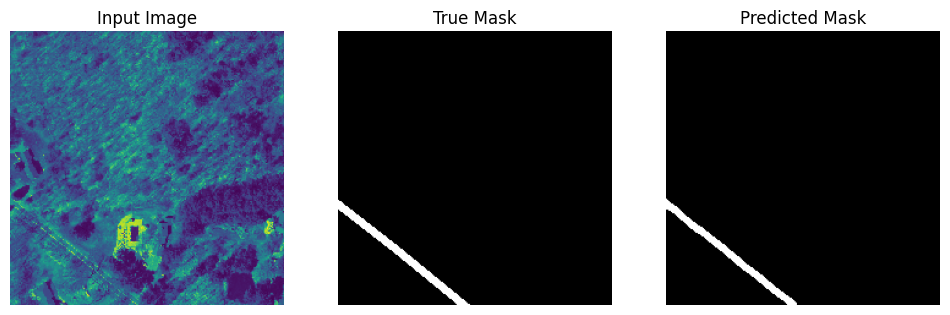

In [ ]:
import torch
import matplotlib.pyplot as plt

# # Load the best model
# checkpoint = torch.load("./checkpoints/best_model.pt", map_location=device)

# # Recreate the model and load weights
# model = UNet(out_channels=300).to(device)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()
# print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")

# Pick a random sample from the test dataset
img, true_mask = next(iter(tst_dl))

# Preprocess image for model input
# input_tensor = tfms(img.copy() / 255.0).unsqueeze(0).to(device)  # shape [1, C, H, W]

# Run inference
with torch.no_grad():
    pred_mask = model(img)
    _, pred_mask = torch.max(pred_mask, dim=1)



    # pred_mask = pred_mask.permute(1,2,0).detach().cpu()[:,:,0]  # shape [H, W]

# Plot input image, true mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(img[0].permute(1,2,0).detach().cpu()[:,:,0])
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(true_mask.permute(1,2,0).detach().cpu()[:,:,0], cmap="gray")
ax[1].set_title("True Mask")
ax[1].axis("off")

ax[2].imshow(pred_mask.permute(1,2,0).detach().cpu()[:,:,0], cmap="gray")
ax[2].set_title("Predicted Mask")
ax[2].axis("off")

plt.show()


Having analysed a few images, the results seem promising. 